## CAMELs sims

Just check we can load and plot the 2D CAMELs fields from IllustrisTNG

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from kymatio.numpy import Scattering2D
from sn_camels.models.models_factory import baseModelFactory, topModelFactory
from sn_camels.models.sn_hybrid_models import sn_HybridModel
import torch

/mnt/home/cpedersen/miniconda3/envs/wavelet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


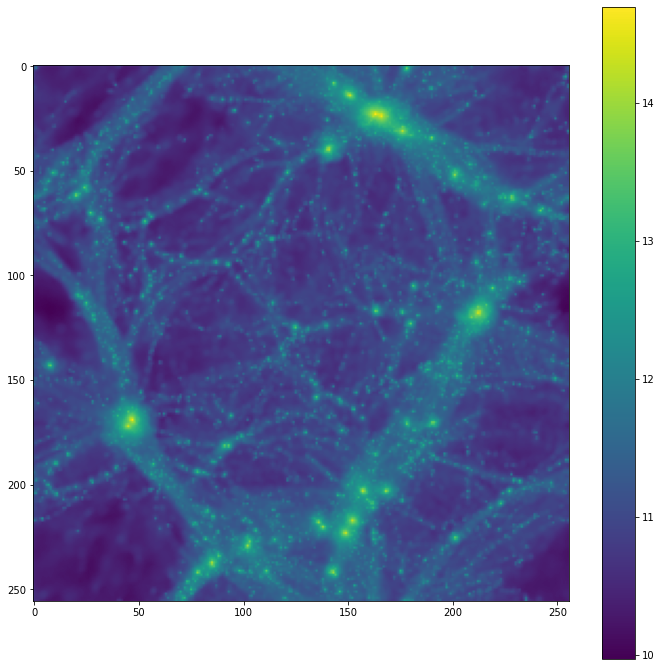

In [2]:
camels_path="/mnt/ceph/users/camels/PUBLIC_RELEASE/CMD/2D_maps/data/"
data_string=camels_path+"/Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy"
param_string=camels_path+"/params_IllustrisTNG.txt"

## Import maps and parameters
maps = np.load(data_string)
params=np.loadtxt(param_string)

maps=maps[:10]

##Pick a field, any field
field_index=np.random.randint(len(maps))

plt.figure(figsize=(12,12))
plt.imshow(np.log10(maps[field_index]))
plt.colorbar()

In [7]:
## Check if CUDA available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
    use_cuda=True
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
    use_cuda=False

CUDA Available


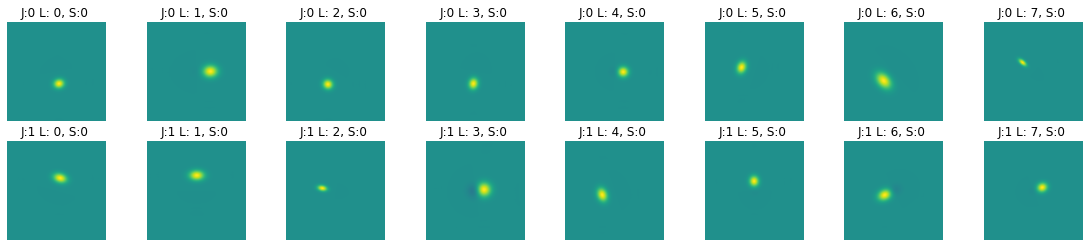

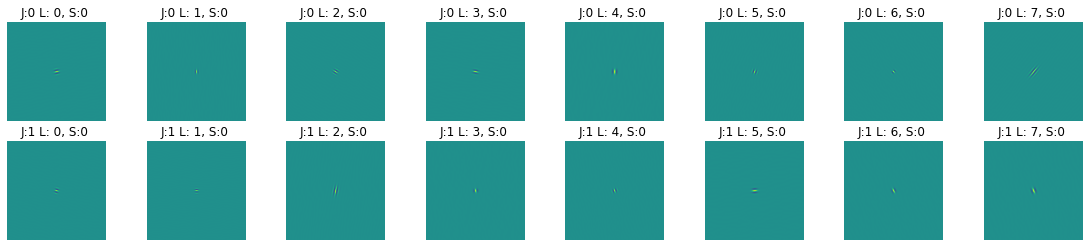

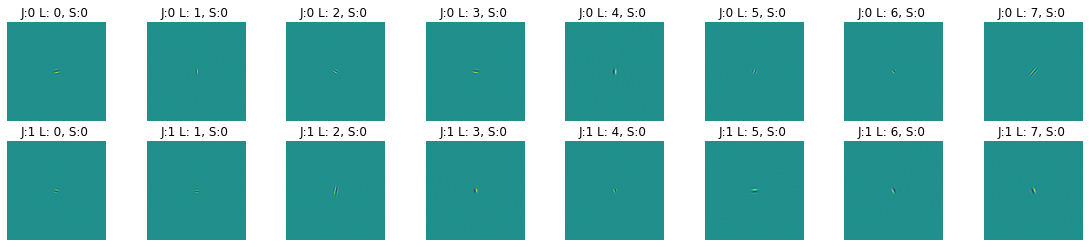

In [8]:
## Make one of our sn_camels models
scatteringBase = baseModelFactory( #creat scattering base model
    architecture='scattering',
    J=2,
    N=256,
    M=256,
    channels=1,
    max_order=2,
    initialization="Random",
    seed=234,
    learnable=True,
    lr_orientation=0.00784,
    lr_scattering=0.00784,
    skip=True,
    split_filters=True,
    filter_video=False,
    subsample=4,
    device=device,
    use_cuda=use_cuda
)


In [9]:
scatteringBase.wavelets

tensor([[[ 5.2445e-09+0.0000e+00j,  6.7214e-05+1.8045e-11j,
           1.3837e-04+6.2121e-12j,  ...,
          -1.6190e-04+4.7567e-12j, -1.1581e-04+3.4116e-12j,
          -6.1484e-05+2.3079e-11j],
         [ 4.1143e-04-4.2819e-10j,  5.1359e-04-3.8417e-11j,
           6.1729e-04+3.1508e-10j,  ...,
           1.3938e-04-1.6658e-09j,  2.2221e-04-1.2503e-09j,
           3.1353e-04-8.3196e-10j],
         [ 1.0348e-03-2.3148e-09j,  1.1884e-03-2.2440e-09j,
           1.3399e-03-2.2333e-09j,  ...,
           5.9934e-04-2.1899e-09j,  7.3685e-04-2.3130e-09j,
           8.8304e-04-2.2956e-09j],
         ...,
         [-5.0494e-04-4.3193e-08j, -4.8694e-04-4.5604e-08j,
          -4.6242e-04-4.7716e-08j,  ...,
          -5.1632e-04-3.4826e-08j, -5.1970e-04-3.7718e-08j,
          -5.1593e-04-4.0531e-08j],
         [-4.1962e-04-4.2262e-08j, -3.9139e-04-4.5081e-08j,
          -3.5698e-04-4.7559e-08j,  ...,
          -4.6110e-04-3.2489e-08j, -4.5478e-04-3.5874e-08j,
          -4.4090e-04-3.9150e-08j],
 

In [10]:
def scattering2d_learn(x, pad, unpad, backend, J, L, phi, psi, max_order,
        out_type='array'):
    """ Function to take an input image and perform a series of scattering
    convolutions."""
    subsample_fourier = backend.subsample_fourier
    modulus = backend.modulus
    fft = backend.fft
    cdgmm = backend.cdgmm
    concatenate = backend.concatenate

    # Define lists for output.
    out_S_0, out_S_1, out_S_2 = [], [], []
    
    ## Map to complex
    complex_maps = x.new_zeros(x.shape + (2,))
    complex_maps[..., 0] = x

    U_0_c = fft(complex_maps, 'C2C')

    # First low pass filter
    U_1_c = cdgmm(U_0_c, phi[0])
    #U_1_c = subsample_fourier(U_1_c, k=2 ** J)


    S_0 = fft(U_1_c, 'C2R', inverse=True)

    out_S_0.append({'coef': S_0,
                    'j': (),
                    'theta': ()})

    for n1 in range(len(psi)):
        j1 = psi[n1]['j'] ## don't care about this any more
        theta1 = psi[n1]['theta']

        ## Wavelet convolution
        U_1_c = cdgmm(U_0_c, psi[n1][0])

        U_1_c = fft(U_1_c, 'C2C', inverse=True)
        U_1_c = modulus(U_1_c)
        U_1_c = fft(U_1_c, 'C2C')

        ## Second low pass filter
        S_1_c = cdgmm(U_1_c, phi[0])
        ## No subsampling for now
        #S_1_c = subsample_fourier(S_1_c, k=2 ** (J))

        S_1_r = fft(S_1_c, 'C2R', inverse=True)

        out_S_1.append({'coef': S_1_r,
                        'j': (j1,),
                        'theta': (theta1,)})

        if max_order < 2:
            continue
        for n2 in range(len(psi)):
            j2 = psi[n2]['j']
            theta2 = psi[n2]['theta']
            

            U_2_c = cdgmm(U_1_c, psi[n2][0])
            # No subsampling for now
            #U_2_c = subsample_fourier(U_2_c, k=2 ** (j2 - j1))
            U_2_c = fft(U_2_c, 'C2C', inverse=True)
            U_2_c = modulus(U_2_c)
            U_2_c = fft(U_2_c, 'C2C')

            ## Low pass filter
            S_2_c = cdgmm(U_2_c, phi[0])
            
            # No subsampling for now
            #S_2_c = subsample_fourier(S_2_c, k=2 ** (J - j2))

            S_2_r = fft(S_2_c, 'C2R', inverse=True)
            

            out_S_2.append({'coef': S_2_r,
                            'j': (j1, j2),
                            'theta': (theta1, theta2)})

    out_S = []
    out_S.extend(out_S_0)
    out_S.extend(out_S_1)
    out_S.extend(out_S_2)

    if out_type == 'array':
        out_S = concatenate([x['coef'] for x in out_S])

    return out_S

In [11]:
out=scattering2d_learn(torch.tensor(maps), scatteringBase.scattering.pad, scatteringBase.scattering.unpad, scatteringBase.scattering.backend, scatteringBase.scattering.J,
                        scatteringBase.scattering.L, scatteringBase.scattering.phi, scatteringBase.scattering.psi, scatteringBase.scattering.max_order, scatteringBase.scattering.out_type)

TypeError: Input must be on GPU.

## Plot some convolutions

In [ ]:
filter_1=2
filter_2=5
order2_index=17+filter_1*16+filter_2

cdm_map_num=7 # between 0 and 10

In [ ]:
plt.figure(figsize=(32,22))
plt.subplot(1, 3, 1)
plt.title("Original field")
plt.imshow(np.log10(maps[cdm_map_num]))
plt.subplot(1, 3, 2)
plt.title("Wavelet filter")
plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[filter_1][0].squeeze().cpu().detach().numpy())).real)
plt.subplot(1, 3, 3)
plt.title("First order convolved field")
plt.imshow(np.log10(out[cdm_map_num][filter_1+1]))
plt.figure(figsize=(32,22))
plt.subplot(1, 3, 1)
plt.title("Original field")
plt.imshow(np.log10(maps[cdm_map_num]))
plt.subplot(1, 3, 2)
plt.title("Wavelet filter")
plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[filter_2][0].squeeze().cpu().detach().numpy())).real)
plt.subplot(1, 3, 3)
plt.title("First order convolved field")
plt.imshow(np.log10(out[cdm_map_num][filter_2+1]))

In [ ]:
plt.figure(figsize=(32,22))
plt.subplot(1, 3, 1)
plt.title("First order 1 field")
plt.imshow(np.log10(out[cdm_map_num][filter_1+1]))
plt.subplot(1, 3, 2)
plt.title("First order 2 field")
plt.imshow(np.log10(out[cdm_map_num][filter_2+1]))
plt.subplot(1, 3, 3)
plt.title("Second order field")
plt.imshow(np.log10(out[cdm_map_num][order2_index]))